# Analysis of Nea. ancestry

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../code/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [3]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

# Calculating Nea ancestry using different ratios of f4 statistics

We used the data set containing the new Vindija sample:

In [4]:
EIGENSTRAT_DIR <- "../data/eigenstrat/bigyri_ho/"

EIGENSTRAT_OLD <- paste0(EIGENSTRAT_DIR, "all")
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "all_HO")

SNP_FILE <- paste0(EIGENSTRAT, ".snp")
GENO_FILE <- paste0(EIGENSTRAT, ".geno")
IND_FILE <- paste0(EIGENSTRAT, ".ind")

In [5]:
subset_sites(prefix=EIGENSTRAT_OLD, out_prefix=EIGENSTRAT, bed_file="../data/bed/bigyri_array.bed", complement=TRUE)

### Calculate the number of SNPs available for each sample on the Human Origins array

In [6]:
geno <- read_geno(GENO_FILE)
ind <- read_ind(IND_FILE)

snp_counts_f4 <- tibble(
    name=ind$label,
    snp_count=t(snps_present(geno))[, 1]
) %>% 
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

<br><br><br><br><br><br><br><br>
# Calculations of Nea ancestry estimate

## Nea. ancestry proportions using David's f4 ratio

In [7]:
merge_pops(IND_FILE, paste0(IND_FILE, ".IceAge"),
           merge=list(West_and_Central_Africans=c("Yoruba", "Mbuti", "Mende"),
                      Nea=c("new_Altai", "new_Vindija")))

In [8]:
my_iceage_Nea <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Nea", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT, ind=paste0(IND_FILE, ".IceAge"))

## Our new f4 ratio estimate

More straightforward & should be measuring what we _really_ want to measure

In [9]:
mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT)
yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT)
dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT)

In [10]:
options(repr.plot.width=9, repr.plot.height=5)

### Merge all f4 results:

In [11]:
non_udg_samples <- c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

results <- bind_rows(list(my_iceage_Nea,
                          mbuti,
                          yoruba,
                          dinka)) %>%
    mutate(name=X, method=setup, se=alpha/Zscore) %>%
    inner_join(samples, .) %>% inner_join(snp_counts_f4)

Joining, by = "name"
Joining, by = "name"


In [12]:
table(results$method)


        qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp 
                                                 151 
        qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp 
                                                 151 
       qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp 
                                                 151 
qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp 
                                                 151 

# Plot Nea. estimates over time

In [13]:
nea_estimates <- results %>% 
    filter(pop %in% c("EMH", "WestEurasia"),
                      !name %in% c("BedouinB", "Druze", "Iranian", "Iraqi_Jew",
                                   "Jordanian", "Palestinian", "Samaritan", "Turkish", "Yemenite_Jew"),
                      !name %in% non_udg_samples)

In [14]:
nea_estimates %>% filter(name == "UstIshim")

name,age,pop,A,B,X,C,O,alpha,stderr,Zscore,setup,method,se,snp_count
UstIshim,45020,EMH,West_and_Central_Africans,Nea,UstIshim,Dinka,Chimp,0.042853,0.004858,8.821,qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp,qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp,0.004858066,1119321
UstIshim,45020,EMH,new_Altai,new_Vindija,UstIshim,Mbuti,Chimp,0.019079,0.004151,4.596,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp,0.004151218,1119321
UstIshim,45020,EMH,new_Altai,new_Vindija,UstIshim,Yoruba,Chimp,0.020493,0.004084,5.018,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp,0.004083898,1119321
UstIshim,45020,EMH,new_Altai,new_Vindija,UstIshim,Dinka,Chimp,0.023033,0.003933,5.857,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp,0.003932559,1119321


In [15]:
plot_nea_vs_time <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=-Inf, ylim=c(0, 0.1), plot_ci=TRUE) {
    x <- if (plot_ci) 1.96 else 0
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>% {(
    ggplot(., aes(age, alpha)) +
        geom_point(aes(size=snp_count, color=abs(Zscore) > 3), alpha=3/4) +
        geom_errorbar(aes(ymin=alpha - x * se, ymax=alpha + x * se, color=abs(Zscore) > 3)) +
        geom_smooth(aes(weight=snp_count), data=filter(., abs(Zscore) > 3), method="lm", linetype=2, fullrange=TRUE, size=0.5) +
        xlim(47000, 0) + ylim(ylim[1], ylim[2]) +
        ggtitle(paste0("analysis setup: ", m))
    )}
}

run_lm <- function(m, z_cutoff=0, snp_cutoff=0, oldest=Inf, youngest=0) {
    filter(nea_estimates,
           method == m,
           age >= youngest,
           age < oldest,
           snp_count >= snp_cutoff,
           is.na(Zscore) | abs(Zscore) >= z_cutoff) %>%
    { lm(.[["age"]] ~ .[["alpha"]], weights = .[["snp_count"]]) } %>% 
    summary
}

## Results from the Ice Age paper

In [16]:
options(repr.plot.width=9, repr.plot.height=5)

<font color="red">Note that we are actually showing 95% CI instead of just std errors, which are pretty meaningless by themselves (and are actually misleading, because they are small).</font>

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 38 rows containing missing values (geom_errorbar).”

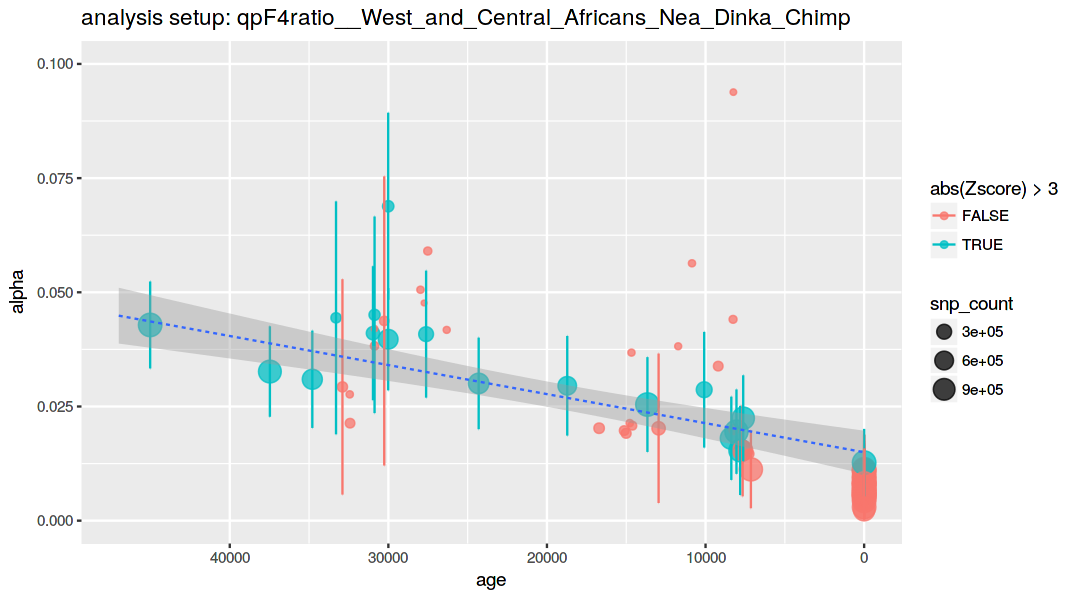

In [17]:
plot_nea_vs_time("qpF4ratio__West_and_Central_Africans_Nea_Dinka_Chimp", ylim=c(0, 0.1))

# New f4 results

In [18]:
options(repr.plot.width=9, repr.plot.height=5)

Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 21 rows containing missing values (geom_errorbar).”

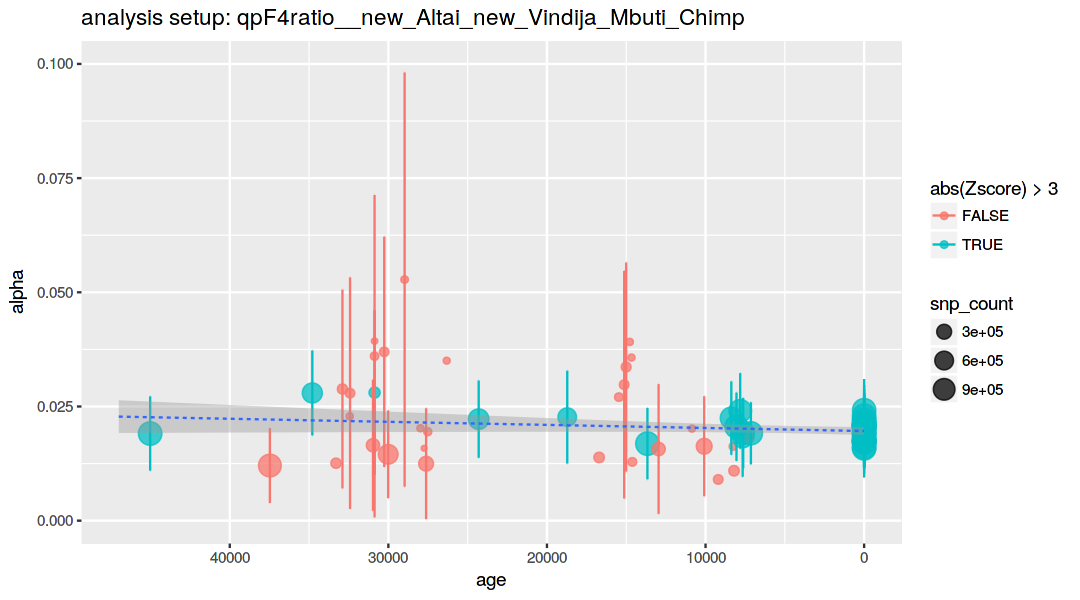

In [19]:
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Mbuti_Chimp")

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 17 rows containing missing values (geom_errorbar).”

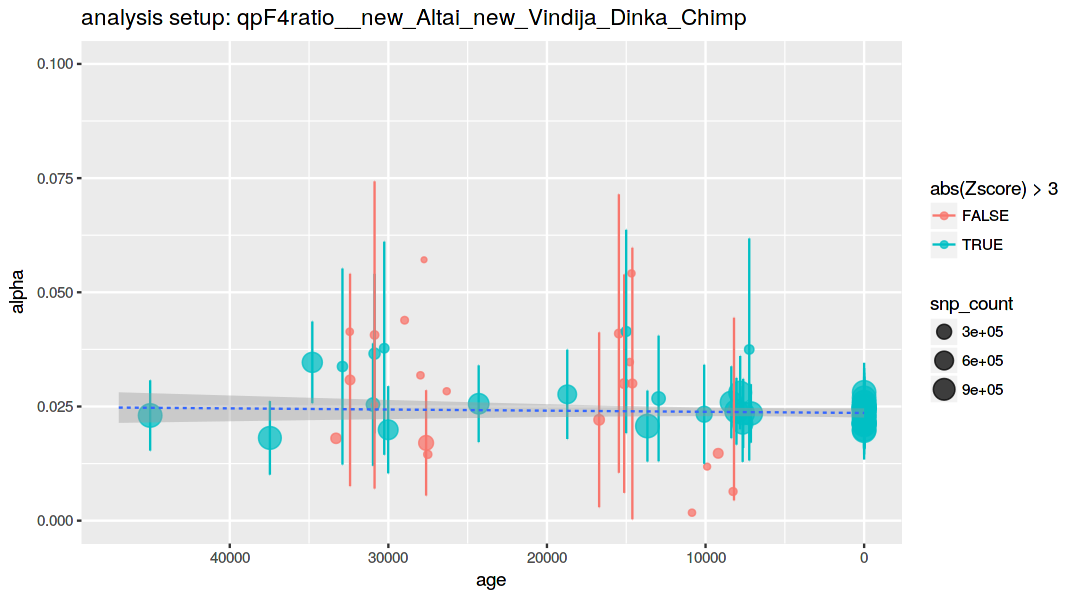

In [20]:
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Dinka_Chimp")

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 22 rows containing missing values (geom_errorbar).”

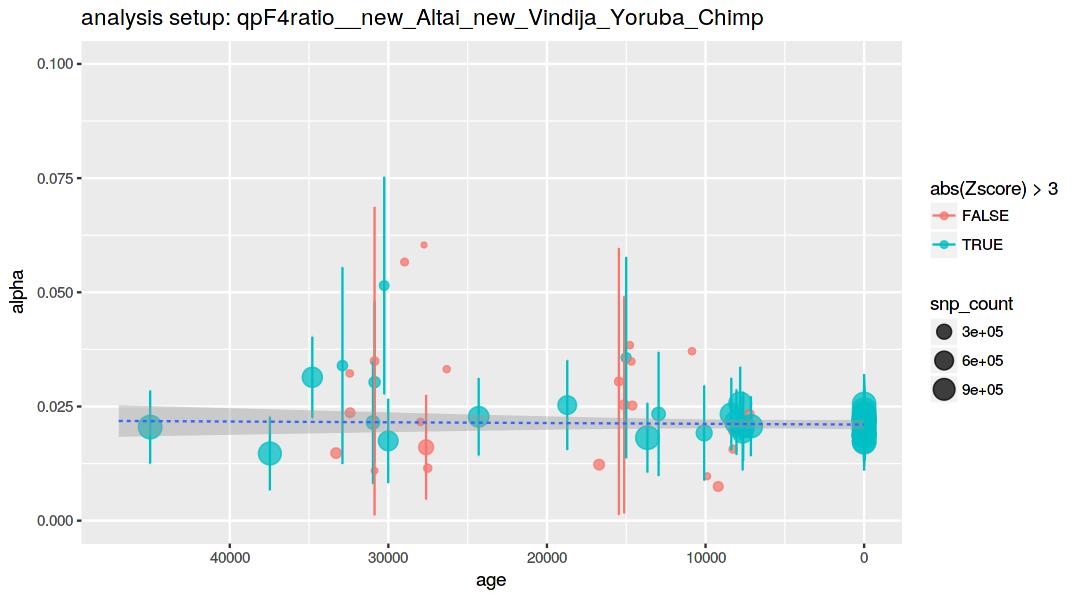

In [21]:
plot_nea_vs_time("qpF4ratio__new_Altai_new_Vindija_Yoruba_Chimp")

# Eur vs Asn

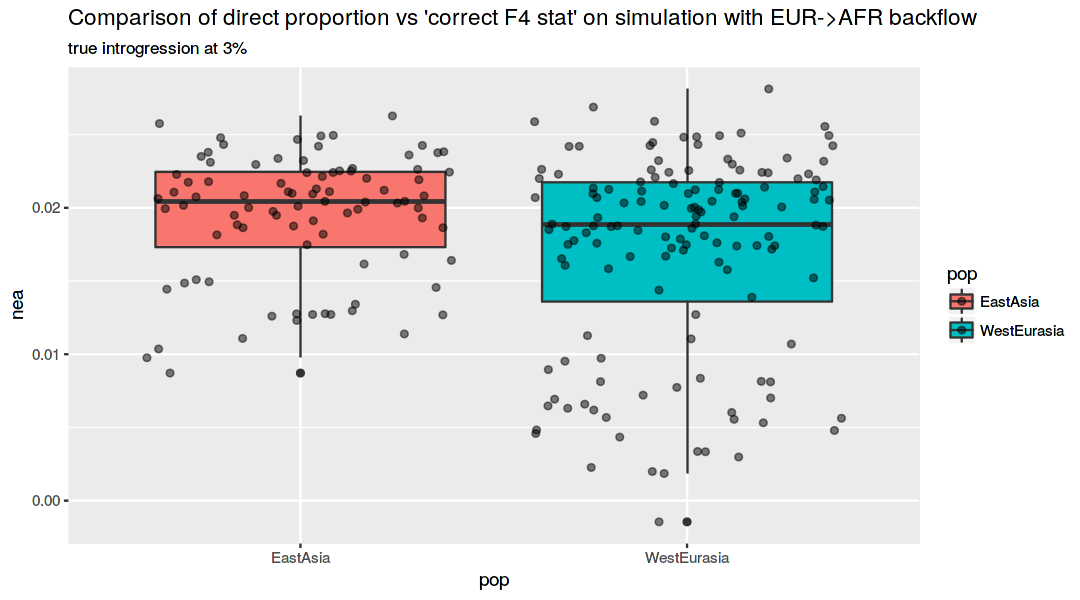

In [22]:
filter(results, pop %in% c("WestEurasia", "EastAsia")) %>% select(pop, nea=alpha) %>%
    gather(pop, nea) %>%
    ggplot(aes(pop, nea, fill=pop)) + geom_boxplot() + geom_jitter(alpha=1/2) +
    ggtitle("Comparison of direct proportion vs 'correct F4 stat' on simulation with EUR->AFR backflow",
            "true introgression at 3%")

In [23]:
save.image("../data/RData/admixtools_nea_ancestry_HO.RData")